ETL

In [1]:
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import sqlite3


# First try to grab the data from SQL
# If that doesn't work (like if we haven't loaded it into SQL yet) it instead pulls it from our csv files
# Then writes those csv files to a sqlite file
try:
    alchemyEngine = create_engine('sqlite:///../Resources/project4.sqlite', echo=False)

    dbConnection = alchemyEngine.connect()

    gender_df = pd.read_sql("SELECT * FROM gender", dbConnection)
    test_df = pd.read_sql("SELECT * FROM test", dbConnection)
    train_df = pd.read_sql("SELECT * FROM train", dbConnection)
    ireland_df = pd.read_sql("SELECT * FROM empress_of_ireland_passenger_list", dbConnection)
    estonia_df = pd.read_sql(("SELECT * FROM estonia_passenger_list", dbConnection))

except:
    gender_df = pd.read_csv("./Resources/gender_submission.csv", sep=";")
    test_df = pd.read_csv("./Resources/test.csv", sep=";")
    train_df = pd.read_csv("./Resources/train.csv", sep=";")
    ireland_df = pd.read_csv("./Resources/empress_of_ireland_passenger_list.csv",sep=";")
    estonia_df = pd.read_csv("./Resources/estonia-passenger-list.csv")

    # After we read from the csv files we load them into a sqlite database, if there isn't one then one is created
    try:
        conn = sqlite3.connect("./Resources/project4.sqlite")

        alchemyEngine = create_engine('sqlite:///../Resources/project4.sqlite', echo=False)

        dbConnection = alchemyEngine.connect()

        gender_df.to_sql("gender_submission", dbConnection, if_exists='fail')
        test_df.to_sql("test", dbConnection, if_exists='fail')
        train_df.to_sql("train", dbConnection, if_exists='fail')
        ireland_df.to_sql("empress_of_ireland_passenger_list", dbConnection, if_exists='fail')
        estonia_df.to_sql("estonia_passenger_list", dbConnection, if_exists='fail')
    except:
        pass



In [2]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,712833.00,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7925.00,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


In [3]:
train_df[["Survived", "Sex", "Age", "Fare"]].groupby("Sex").mean()

,Survived,Age,Fare
Sex,,,
female,0.742038,27.915709,178603.236465
male,0.188908,30.726645,99179.827123


ETL on the Empress of Ireland

In [4]:
# This Dataset was made by hand so its bound to have some missing or incorrect data in it
# Since I made this dataset with this project in mind, there isn't a lot of ETL to be done on it (other than when I was typing it up)

ireland_df.count()

# The counts appear to be little off

Survived    1469
Pclass      1469
Name        1469
Sex         1468
Age          809
dtype: int64

In [5]:
ireland_df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age'], dtype='object')

In [6]:
# I want to check that all the categories are correct
survived_unique = ireland_df["Survived"].unique()
pclass_unique = ireland_df["Pclass"].unique()
sex_unique = ireland_df["Sex"].unique()

print(f"Unique values for 'Survived' (this should be 1,0): {survived_unique}")
print(f"Unique values for 'Pclass' (this should be 0,1,2,3): {pclass_unique}")
print(f"Unique values for 'Sex' (this should be male/female/nan): {sex_unique}")

# Looks like they are

Unique values for 'Survived' (this should be 1,0): [1 0]
Unique values for 'Pclass' (this should be 0,1,2,3): [0 1 2 3]
Unique values for 'Sex' (this should be male/female/nan): ['male' 'female' nan]


In [7]:
ireland_df.head()

,Survived,Pclass,Name,Sex,Age
0,1,0,Kendall. Henry George,male,NaN
1,0,0,Steede. Mansfield Richard,male,NaN
2,1,0,Jones. Edward John,male,NaN
3,0,0,Williams. Roger,male,NaN
4,1,0,File. Osmond,male,NaN


In [8]:
# The expected numbers are taken from wikipedia, I've gone over the passenger and crew list that I had and couldn't find anything missing
# so either Wikipedia or the list I was looking at was wrong

ireland_df.loc[ireland_df["Pclass"] == 0].count()
#Missing 3 crew members (expected 420)

Survived    417
Pclass      417
Name        417
Sex         417
Age           0
dtype: int64

In [9]:
ireland_df.loc[ireland_df["Pclass"] == 1].count()
# I have 1 extra 1st class passenger (expected 87)

Survived    88
Pclass      88
Name        88
Sex         88
Age         87
dtype: int64

In [10]:
ireland_df.loc[ireland_df["Pclass"] == 2].count()
# Missing 1 2nd class passenger (expected 253)

Survived    252
Pclass      252
Name        252
Sex         252
Age         234
dtype: int64

In [11]:
# Third class passengers I haven't double checked yet, its a lot of data to go through by hand, and I think this is close enough

ireland_df.loc[ireland_df["Pclass"] == 3].count()
# Missing 5 3rd class pasengers (expected 717)

Survived    712
Pclass      712
Name        712
Sex         711
Age         488
dtype: int64

In [12]:
ireland_df.groupby(["Pclass"]).mean()

,Survived,Age
Pclass,,
0,0.558753,NaN
1,0.375000,39.080460
2,0.194444,30.924786
3,0.185393,29.055266


In [13]:
# Average Age of the survivors

ireland_df.loc[ireland_df["Survived"] == 1].groupby("Pclass").mean()["Age"]

Pclass
0          NaN
1    35.500000
2    31.156250
3    32.440367
Name: Age, dtype: float64

In [14]:
# Average age of those who died

ireland_df.loc[ireland_df["Survived"] == 0].groupby("Pclass").mean()["Age"]

Pclass
0          NaN
1    41.163636
2    30.865054
3    28.081715
Name: Age, dtype: float64

In [15]:
ireland_df.dtypes


Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
dtype: object

Now for ETL on the estonia passenger list

In [16]:
# Format the names like they are in the Titanic dataset (I don't think we're going to add Mr. or Mrs. like they are in the Titanic and Empress of Ireland)
estonia_df["Name"] = estonia_df["Lastname"].str.title() + ', ' + estonia_df["Firstname"].str.title()

# Change how gender is displayed
estonia_df.loc[estonia_df["Sex"] == "M", "Sex"] = "male"
estonia_df.loc[estonia_df["Sex"] == "F", "Sex"] = "female"

# Change the column called Category to Pclass that only contains 1 (for passenger) and 0 (for crew) to match the Empress of Ireland dataset

estonia_df.rename(columns = {"Category":"Pclass"}, inplace=True)

estonia_df.loc[estonia_df["Pclass"] == "P", "Pclass"] = 1
estonia_df.loc[estonia_df["Pclass"] == "C", "Pclass"] = 0

estonia_df = estonia_df.astype({"Pclass": int})

estonia_df.head()

,PassengerId,Country,Firstname,Lastname,Sex,Age,Pclass,Survived,Name
0,1,Sweden,ARVID KALLE,AADLI,male,62,1,0,"Aadli, Arvid Kalle"
1,2,Estonia,LEA,AALISTE,female,22,0,0,"Aaliste, Lea"
2,3,Estonia,AIRI,AAVASTE,female,21,0,0,"Aavaste, Airi"
3,4,Sweden,JURI,AAVIK,male,53,0,0,"Aavik, Juri"
4,5,Sweden,BRITTA ELISABET,AHLSTROM,female,55,1,0,"Ahlstrom, Britta Elisabet"


In [17]:
new_estonia_df = estonia_df[["Survived", "Pclass", "Name", "Sex", "Age"]]
new_estonia_df.head()

,Survived,Pclass,Name,Sex,Age
0,0,1,"Aadli, Arvid Kalle",male,62
1,0,0,"Aaliste, Lea",female,22
2,0,0,"Aavaste, Airi",female,21
3,0,0,"Aavik, Juri",male,53
4,0,1,"Ahlstrom, Britta Elisabet",female,55


In [18]:
new_estonia_df.dtypes

Survived     int64
Pclass       int32
Name        object
Sex         object
Age          int64
dtype: object

In [19]:
new_estonia_df["Survived"].unique()

array([0, 1], dtype=int64)

In [20]:
# Now save the cleaned dataframe

new_estonia_df.to_csv("./Resources/estonia-passenger-list-cleaned.csv", index=False)

Machine Learning

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [22]:
# Load up the csv files from the database

# If run after the previous block of code we use the cleaned version of the estonia we just created
# If this block is run on its ovwn then new_estonia_df is not defined and we get an exception then read from the csv that we saved
try:
    estonia = new_estonia_df
except:
    estonia = pd.read_csv("./Resources/estonia-passenger-list-cleaned.csv",sep=",")

ireland = pd.read_csv("./Resources/empress_of_ireland_passenger_list.csv", sep=";")

titanic_train = pd.read_csv("./Resources/train.csv",sep=";")
titanic_test = pd.read_csv("./Resources/test.csv",sep=";")

survived = pd.read_csv("./Resources/gender_submission.csv",sep=",")

# The Titanic dataset that we downloaded has alread been split into test and train sets, with the target for the test in a differnt csv file, so we join them here

titanic_test = titanic_test.set_index("PassengerId").join(survived.set_index("PassengerId"), on="PassengerId")

In [23]:
survived.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [24]:
estonia.head()

,Survived,Pclass,Name,Sex,Age
0,0,1,"Aadli, Arvid Kalle",male,62
1,0,0,"Aaliste, Lea",female,22
2,0,0,"Aavaste, Airi",female,21
3,0,0,"Aavik, Juri",male,53
4,0,1,"Ahlstrom, Britta Elisabet",female,55


In [25]:
# We want only the columns of the Titanic dataset that match the columns in the Empress of Ireland and the Estonia

columns = estonia.columns

titanic_test = titanic_test[columns]
titanic_train = titanic_train[columns]

titanic_train.head()

# Now we combine our the test and train into a single Titanic dataset
titanic_combined = pd.concat([titanic_test, titanic_train])

In [26]:
# Right now we have the class as an integer and the sex as a string
# To fix this we make categoricals out of them, with 4 columns describing the class (0 for crew, 1 for 1st, etc.)

categoricals = titanic_combined[["Survived", "Pclass", "Sex", "Age"]].astype({"Pclass":"str"}).select_dtypes(exclude=['int64', 'float64'])
categorical_dummies = pd.get_dummies(categoricals, drop_first=False)

numericals = titanic_combined.drop(categoricals,axis=1)[["Survived","Age"]]

titanic_categorical= pd.concat([numericals, categorical_dummies], axis=1)

# Pclass_0 is used in the empress of ireland and the estonia dataset to describe crew
# We add this column to the Titanic dataset
titanic_categorical["Pclass_0"] = 0
titanic_categorical.head()


,Survived,Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Pclass_0
892,0,34.5,0,0,1,0,1,0
893,1,47.0,0,0,1,1,0,0
894,0,62.0,0,1,0,0,1,0
895,0,27.0,0,0,1,0,1,0
896,1,22.0,0,0,1,1,0,0


In [27]:
categoricals = ireland[["Survived", "Pclass", "Sex", "Age"]].astype({"Pclass":"str"}).select_dtypes(exclude=['int64', 'float64'])
categorical_dummies = pd.get_dummies(categoricals, drop_first=False)

numericals = ireland.drop(categoricals,axis=1)[["Survived","Age"]]

ireland_categorical = pd.concat([numericals, categorical_dummies], axis=1)
ireland_categorical.head()

,Survived,Age,Pclass_0,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,1,NaN,1,0,0,0,0,1
1,0,NaN,1,0,0,0,0,1
2,1,NaN,1,0,0,0,0,1
3,0,NaN,1,0,0,0,0,1
4,1,NaN,1,0,0,0,0,1


In [28]:
categoricals = estonia[["Survived", "Pclass", "Sex", "Age"]].astype({"Pclass":"str"}).select_dtypes(exclude=['int64', 'float64'])
categorical_dummies = pd.get_dummies(categoricals, drop_first=False)

numericals = estonia.drop(categoricals,axis=1)[["Survived","Age"]]

estonia_categorical = pd.concat([numericals, categorical_dummies], axis=1)

# The estonia only had information about crew and passengers, we decided make all the passengers 2nd class as a middle ground between 1st and 3rd, so we have to rename this column
estonia_categorical.rename({"Pclass_1":"Pclass_3"}, axis=1, inplace=True)

estonia_categorical["Pclass_1"] = 0
estonia_categorical["Pclass_2"] = 0

# We also want to reorder the columns to match each other, using the column order from the empress of ireland dataset

estonia_categorical = estonia_categorical[ireland_categorical.columns]
titanic_categorical = titanic_categorical[ireland_categorical.columns]

estonia_categorical.head()

,Survived,Age,Pclass_0,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,62,0,0,0,1,0,1
1,0,22,1,0,0,0,1,0
2,0,21,1,0,0,0,1,0
3,0,53,1,0,0,0,0,1
4,0,55,0,0,0,1,1,0


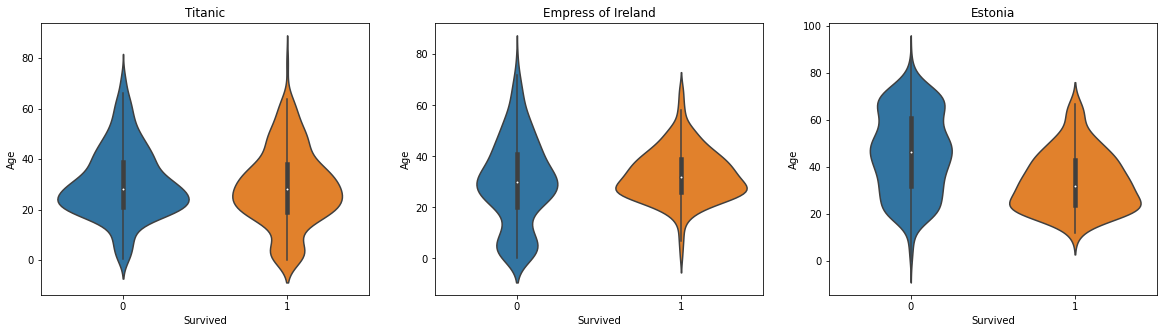

In [29]:
# Violin plot of the distribution of ages among those who survived or didn't 

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

sns.violinplot(data=titanic_combined, x="Survived",y="Age", ax=ax1)
ax1.set_title("Titanic")

sns.violinplot(data=ireland, x="Survived",y="Age", ax=ax2)
ax2.set_title("Empress of Ireland")

sns.violinplot(data=estonia, x="Survived",y="Age", ax=ax3)
ax3.set_title("Estonia")

plt.show()

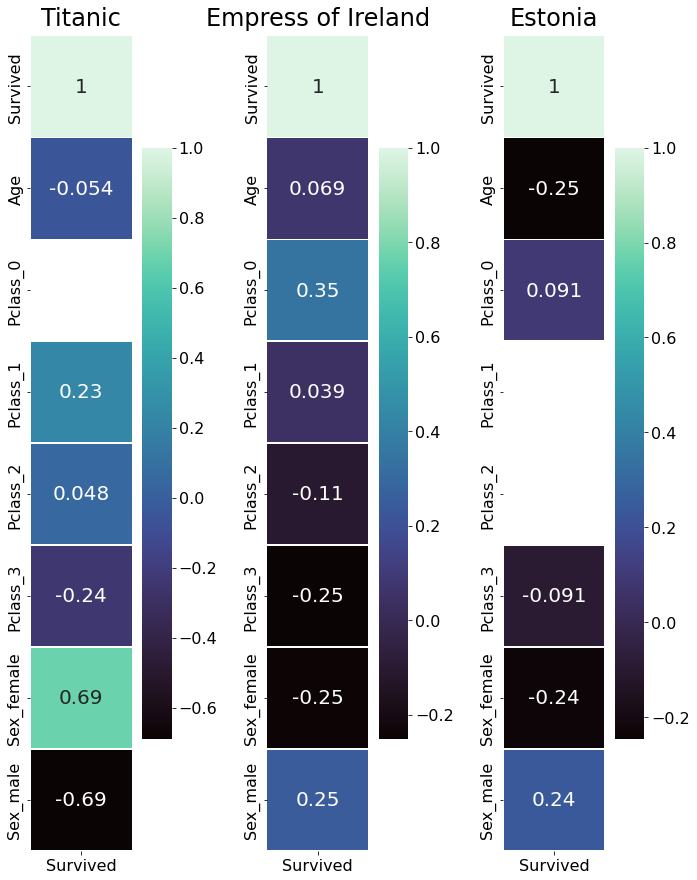

In [30]:
# Correlation heatmap for the Titanic, Empress of Ireland and Estonia

plt.rcParams.update({'font.size': 16})

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,15))

titanic_corr = titanic_categorical.corr()[["Survived"]]
ireland_corr = ireland_categorical.corr()[["Survived"]]
estonia_corr = estonia_categorical.corr()[["Survived"]]

fontsize_titles = 24
annot_format = {
    "fontsize": 20
}


sns.heatmap(titanic_corr, ax=ax1, cbar=True, square=True, annot=True, linewidth=0.5, annot_kws=annot_format, cmap="mako")
ax1.set_title("Titanic", pad=10, fontsize=fontsize_titles)

sns.heatmap(ireland_corr, ax=ax2, cbar=True, square=True, annot=True, linewidth=0.5, annot_kws=annot_format, cmap="mako")
ax2.set_title("Empress of Ireland",pad=10, fontsize=fontsize_titles)
ax2.tick_params(
    axis='y',  
    which='both',
    bottom=False,
    top=False,
    labelbottom=False) 

sns.heatmap(estonia_corr,ax=ax3, cbar=True, square=True, annot=True, linewidth=0.5, annot_kws=annot_format, cmap="mako")
ax3.set_title("Estonia",pad=10, fontsize=fontsize_titles)

plt.show()

In [31]:
list(titanic_corr.index)


['Survived',
 'Age',
 'Pclass_0',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male']

In [32]:
titanic_corr

,Survived
Survived,1.000000
Age,-0.053695
Pclass_0,NaN
Pclass_1,0.234338
Pclass_2,0.048091
Pclass_3,-0.242183
Sex_female,0.688371
Sex_male,-0.688371


In [33]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [34]:
# I've been keeping the empty rows around, but we have to get rid of them before going into machine learning

titanic_categorical.dropna(inplace=True)
ireland_categorical.dropna(inplace=True)
estonia_categorical.dropna(inplace=True)

# Now we split each into targets and features

target_titanic = titanic_categorical["Survived"]
features_titanic = titanic_categorical.drop(["Survived"], axis=1)

target_ireland = ireland_categorical["Survived"]
features_ireland = ireland_categorical.drop(["Survived"], axis=1)

target_estonia = estonia_categorical["Survived"]
features_estonia = estonia_categorical.drop(["Survived"], axis=1)

In [35]:
features_titanic.head()

,Age,Pclass_0,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
892,34.5,0,0,0,1,0,1
893,47.0,0,0,0,1,1,0
894,62.0,0,0,1,0,0,1
895,27.0,0,0,0,1,0,1
896,22.0,0,0,0,1,1,0


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


import tensorflow as tf

import keras_tuner
from tensorflow import keras

# Here I define a bunch of functions to help automate creating the machine learning classifiers, since we're going to make a bunch of them

def create_logistic_regression(features, target, random_state=0):
    clf = LogisticRegression(random_state=0)

    clf.fit(features, target)

    return clf

def create_random_forest(features, target, random_state=0):
    clf = RandomForestClassifier(max_depth=2, random_state=0)

    clf.fit(features, target)

    return clf

def create_svm(features, target, random_state=0):
    clf = svm.SVC()
    clf.fit(features, target)

    return clf

def create_neural_net(X_train, X_test, y_train, y_test, random_state=0):

    nn=tf.keras.models.Sequential()
    nn.add(tf.keras.layers.Dense(units=5, activation="relu", input_dim=7))
    nn.add(tf.keras.layers.Dense(units=10, activation="relu"))
    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    fit_model = nn.fit(X_train, y_train, epochs=20)
    nn_accuracy = nn.evaluate(X_test, y_test)[1]
    
    return nn, nn_accuracy


# This function takes a set of features and targets, splits them into test and train, and returns 3 classifiers
def create_clf(features, target, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=random_state)

    accuracy_results = []

    logistic_regression = create_logistic_regression(X_train, y_train, random_state=random_state)
    accuracy_results.append(clf_prediction(logistic_regression, X_test, y_test))

    random_forest = create_random_forest(X_train, y_train, random_state=random_state)
    accuracy_results.append(clf_prediction(random_forest, X_test, y_test))

    svm_model = create_svm(X_train, y_train, random_state=random_state)
    accuracy_results.append(clf_prediction(svm_model, X_test, y_test))

    nn, nn_accuracy = create_neural_net( X_train, X_test, y_train, y_test, random_state=random_state)
    accuracy_results.append(nn_accuracy)
    

    return [logistic_regression, random_forest, svm_model, nn], accuracy_results


# Takes a classifier (either logistic regression or random forest) alongside features and targets and checks to see how many times the classifier got it right
def clf_prediction(clf, features, target):
    prediction = clf.predict(features)

    total_correct = 0

    for i in range(len(prediction)):
        if prediction[i] == target.iloc[i]:
            total_correct += 1

    accuracy = total_correct/len(target)
    return accuracy

In [37]:
# Here we make a bunch of empty dictionaries that we will populate in the next block

datasets = {
    "Titanic":{
        "features":features_titanic,
        "target":target_titanic,
        "classifiers":[]
    },
    "Empress of Ireland":{
        "features":features_ireland,
        "target":target_ireland,
        "classifiers":[]
    },
    "Estonia":{
        "features":features_estonia,
        "target":target_estonia,
        "classifiers":[]
    }
}

logistic_regression_accuracy = {
    "trained on titanic":[], 
    "trained on ireland":[], 
    "trained on estonia":[]
}

random_forest_accuracy = {
    "trained on titanic":[], 
    "trained on ireland":[], 
    "trained on estonia":[]
}

svm_accuracy = {
    "trained on titanic":[], 
    "trained on ireland":[], 
    "trained on estonia":[]
}

nn_accuracy = {
    "trained on titanic":[], 
    "trained on ireland":[], 
    "trained on estonia":[]
}



total_accuracy = {
    "Logistic Regression":[],
    "Random Forest":[],    
    "SVM":[],
    "Neural Net":[]
}

In [38]:
# create 3 sets of classifiers trained on each of the 3 datasets

datasets["Titanic"]["classifiers"], titanic_accuracy = create_clf(datasets["Titanic"]["features"], datasets["Titanic"]["target"])
datasets["Empress of Ireland"]["classifiers"], ireland_accuracy = create_clf(datasets["Empress of Ireland"]["features"], datasets["Empress of Ireland"]["target"])
datasets["Estonia"]["classifiers"], estonia_accuracy = create_clf(datasets["Estonia"]["features"], datasets["Estonia"]["target"])

print(titanic_accuracy)
print(ireland_accuracy)
print(estonia_accuracy)


# This function takes a single classifier and checks its accuracy against the 3 datasets returning a list of numbers between 0 and 1
def create_accuracy_row(clf):

    results = [
        clf_prediction(clf, datasets["Titanic"]["features"], datasets["Titanic"]["target"]),
        clf_prediction(clf, datasets["Empress of Ireland"]["features"], datasets["Empress of Ireland"]["target"]),
        clf_prediction(clf, datasets["Estonia"]["features"], datasets["Estonia"]["target"])
    ]
    return results

# Does the same thing, but for a neural net
def create_accuracy_row_nn(nn):
    results = [
        nn.evaluate(datasets["Titanic"]["features"], datasets["Titanic"]["target"])[1],
        nn.evaluate(datasets["Empress of Ireland"]["features"], datasets["Empress of Ireland"]["target"])[1],
        nn.evaluate(datasets["Estonia"]["features"], datasets["Estonia"]["target"])[1]
    ]
    return results

# Now we populate each row in the accuracy dictionaries to create a matrix
logistic_regression_accuracy["trained on titanic"] = create_accuracy_row(datasets["Titanic"]["classifiers"][0])
logistic_regression_accuracy["trained on ireland"] = create_accuracy_row(datasets["Empress of Ireland"]["classifiers"][0])
logistic_regression_accuracy["trained on estonia"] = create_accuracy_row(datasets["Estonia"]["classifiers"][0])

random_forest_accuracy["trained on titanic"] = create_accuracy_row(datasets["Titanic"]["classifiers"][1])
random_forest_accuracy["trained on ireland"] = create_accuracy_row(datasets["Empress of Ireland"]["classifiers"][1])
random_forest_accuracy["trained on estonia"] = create_accuracy_row(datasets["Estonia"]["classifiers"][1])

svm_accuracy["trained on titanic"] = create_accuracy_row(datasets["Titanic"]["classifiers"][2])
svm_accuracy["trained on ireland"] = create_accuracy_row(datasets["Empress of Ireland"]["classifiers"][2])
svm_accuracy["trained on estonia"] = create_accuracy_row(datasets["Estonia"]["classifiers"][2])

nn_accuracy["trained on titanic"] = create_accuracy_row_nn(datasets["Titanic"]["classifiers"][3])
nn_accuracy["trained on ireland"] = create_accuracy_row_nn(datasets["Empress of Ireland"]["classifiers"][3])
nn_accuracy["trained on estonia"] = create_accuracy_row_nn(datasets["Estonia"]["classifiers"][3])





Epoch 1/20
25/25 [==============================] - 1s 1ms/step - loss: 0.7335 - accuracy: 0.4579
Epoch 2/20
25/25 [==============================] - 0s 947us/step - loss: 0.6813 - accuracy: 0.5829
Epoch 3/20
25/25 [==============================] - 0s 932us/step - loss: 0.6786 - accuracy: 0.5842
Epoch 4/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6759 - accuracy: 0.5842
Epoch 5/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6719 - accuracy: 0.5842
Epoch 6/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6676 - accuracy: 0.5893
Epoch 7/20
25/25 [==============================] - 0s 819us/step - loss: 0.6606 - accuracy: 0.5995
Epoch 8/20
25/25 [==============================] - 0s 806us/step - loss: 0.6345 - accuracy: 0.7194
Epoch 9/20
25/25 [==============================] - 0s 859us/step - loss: 0.5891 - accuracy: 0.7717
Epoch 10/20
25/25 [==============================] - 0s 833us/step - loss: 0.5666 - accuracy: 0.7972
Epoch 1

In [39]:
# Now we combine all three datasets into one and use it to train the three classifiers

total_features = pd.concat([features_titanic, features_ireland, features_estonia])
total_targets = pd.concat([target_titanic, target_ireland, target_estonia])

X_train, X_test, y_train, y_test = train_test_split(total_features, total_targets, random_state=0)

total_clf, total_accuracy_rating = create_clf(X_train, y_train)

total_accuracy = {
    "Logistic Regression":[],
    "Random Forest":[],
    "SVM":[],
    "Neural Net":[]
}

# Then we check the accuracy of each classifier against the three original datasets

total_accuracy["Logistic Regression"] = create_accuracy_row(total_clf[0])
total_accuracy["Random Forest"] = create_accuracy_row(total_clf[1])
total_accuracy["SVM"] = create_accuracy_row(total_clf[2])
total_accuracy["Neural Net"] = create_accuracy_row_nn(total_clf[3])



# Finally insert to the 0 index the accuracy evaluation of the total dataset to compare it to
total_accuracy["Logistic Regression"].insert(0,clf_prediction(total_clf[0], X_test, y_test))
total_accuracy["Random Forest"].insert(0,clf_prediction(total_clf[1], X_test, y_test))
total_accuracy["SVM"].insert(0,clf_prediction(total_clf[2], X_test, y_test))
total_accuracy["Neural Net"].insert(0, total_clf[3].evaluate(X_test, y_test)[1])



Epoch 1/20
50/50 [==============================] - 0s 876us/step - loss: 1.0534 - accuracy: 0.3940
Epoch 2/20
50/50 [==============================] - 0s 1ms/step - loss: 0.5631 - accuracy: 0.7398
Epoch 3/20
50/50 [==============================] - 0s 1ms/step - loss: 0.5603 - accuracy: 0.7405
Epoch 4/20
50/50 [==============================] - 0s 1ms/step - loss: 0.5581 - accuracy: 0.7411
Epoch 5/20
50/50 [==============================] - 0s 1ms/step - loss: 0.5560 - accuracy: 0.7417
Epoch 6/20
50/50 [==============================] - 0s 1ms/step - loss: 0.5553 - accuracy: 0.7411
Epoch 7/20
50/50 [==============================] - 0s 970us/step - loss: 0.5533 - accuracy: 0.7430
Epoch 8/20
50/50 [==============================] - 0s 838us/step - loss: 0.5498 - accuracy: 0.7442
Epoch 9/20
50/50 [==============================] - 0s 700us/step - loss: 0.5472 - accuracy: 0.7436
Epoch 10/20
50/50 [==============================] - 0s 1ms/step - loss: 0.5461 - accuracy: 0.7436
Epoch 11/20

In [40]:
# Nearly there; we convert the accuracy matricies into pandas dataframes so we can graph them
# And label the index and columns to something readable

ship_list = ["Titanic", "Empress of Ireland", "Estonia"]

lr_accuracy_df = pd.DataFrame(logistic_regression_accuracy)
lr_accuracy_df.index = ship_list
lr_accuracy_df.columns = ship_list

rf_accuracy_df = pd.DataFrame(random_forest_accuracy)
rf_accuracy_df.index = ship_list
rf_accuracy_df.columns = ship_list

nn_accuracy_df = pd.DataFrame(nn_accuracy)
nn_accuracy_df.index = ship_list
nn_accuracy_df.columns = ship_list

svm_accuracy_df = pd.DataFrame(svm_accuracy)
svm_accuracy_df.index = ship_list
svm_accuracy_df.columns = ship_list

total_accuracy_df = pd.DataFrame(total_accuracy).transpose()
total_accuracy_df.columns = ["Total", "Titanic", "Empress of Ireland", "Estonia"]


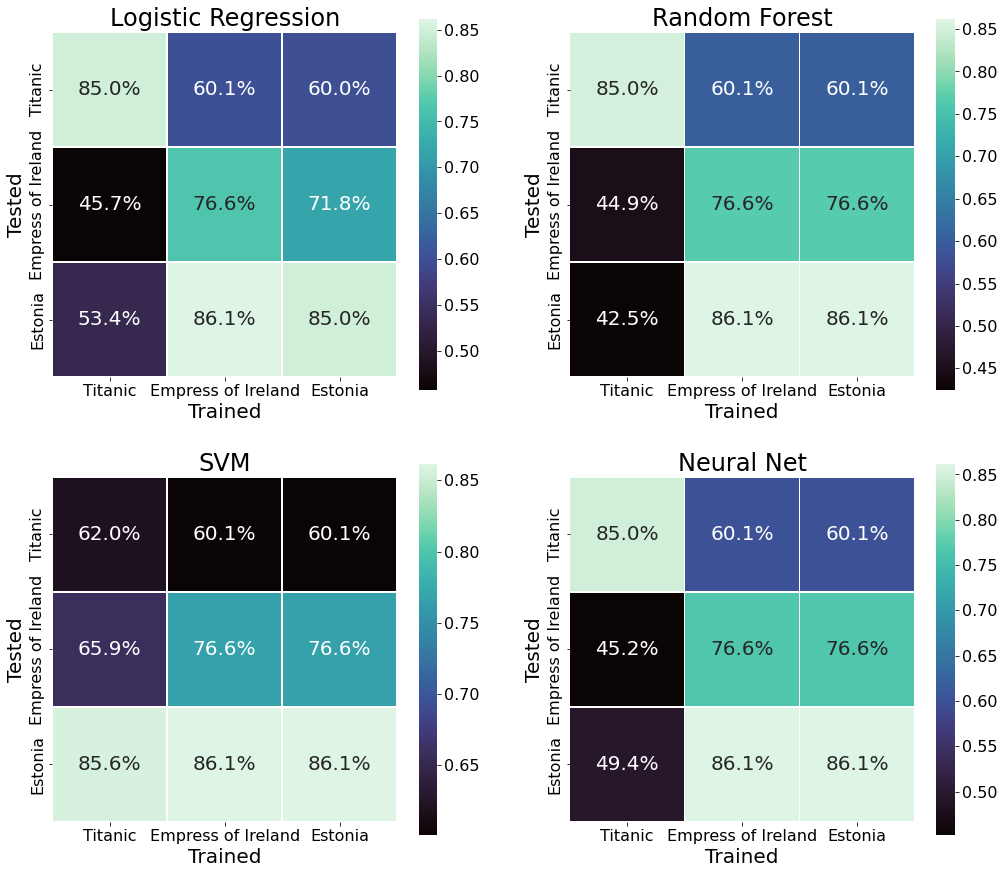

In [41]:
# These graphs show a 3x4 grid with the columns being which datasets the classifier was trained on and the rows being which ones it was tested on

fig, axs = plt.subplots(2,2,figsize=(17,15))

plt.rcParams.update({'font.size': 16})

fontsize_labels=20
fontsize_titles=24
fontsize_yticks= 18
annot_format = {
    "fontsize": 20
}

sns.heatmap(lr_accuracy_df, ax=axs[0,0], cbar=True, annot=True, square=True, linewidth=0.5, fmt="0.1%", annot_kws=annot_format, cmap="mako")
axs[0,0].set_title("Logistic Regression", fontsize=fontsize_titles)
axs[0,0].set_xlabel("Trained", fontsize=fontsize_labels)
axs[0,0].set_ylabel("Tested", fontsize=fontsize_labels)
#axs[0,0].set_yticks(["RMS Titanic", "RMS Empress of Ireland", "MS Estonia"], fontsize=fontsize_yticks)

sns.heatmap(rf_accuracy_df, ax=axs[0,1], cbar=True, annot=True, square=True, linewidth=0.5, fmt="0.1%", annot_kws=annot_format, cmap="mako")
axs[0,1].set_title("Random Forest", fontsize=fontsize_titles)
axs[0,1].set_xlabel("Trained", fontsize=fontsize_labels)
axs[0,1].set_ylabel("Tested", fontsize=fontsize_labels)

sns.heatmap(svm_accuracy_df, ax=axs[1,0], cbar=True, annot=True, square=True, linewidth=0.5, fmt="0.1%", annot_kws=annot_format, cmap="mako")
axs[1,0].set_title("SVM", fontsize=fontsize_titles)
axs[1,0].set_xlabel("Trained", fontsize=fontsize_labels)
axs[1,0].set_ylabel("Tested", fontsize=fontsize_labels)

sns.heatmap(nn_accuracy_df, ax=axs[1,1], cbar=True, annot=True, square=True, linewidth=0.5, fmt="0.1%", annot_kws=annot_format, cmap="mako")
axs[1,1].set_title("Neural Net", fontsize=fontsize_titles)
axs[1,1].set_xlabel("Trained", fontsize=fontsize_labels)
axs[1,1].set_ylabel("Tested", fontsize=fontsize_labels)

plt.show()

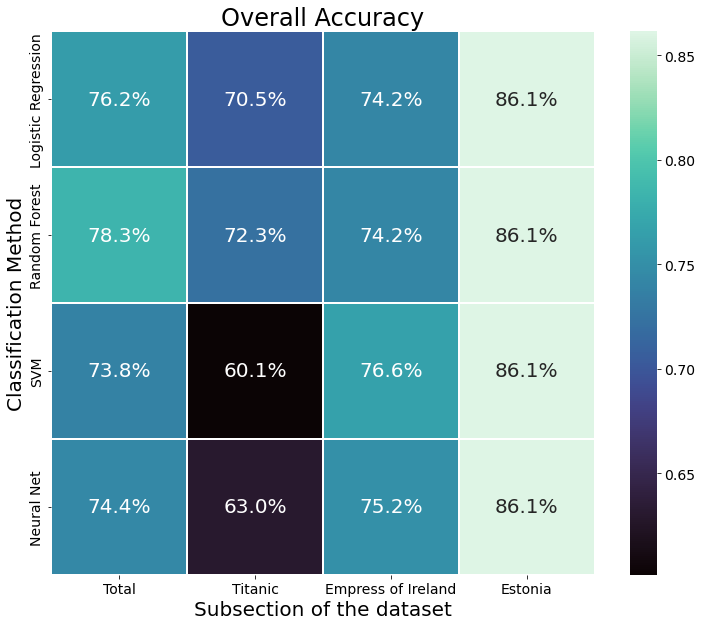

In [42]:
# And finally a plot of the accuracy of the total dataset, rows indicating the classifier method used and the columns showing the subset that each one was tested against

plt.rcParams.update({'font.size': 14})

fontsize_labels=20
fontsize_titles=24

fig, ax = plt.subplots(1,1, figsize=(12.5,10))
sns.heatmap(total_accuracy_df, ax=ax, cbar=True, annot=True, square=True, linewidth=0.5, fmt="0.1%", annot_kws=annot_format, cmap="mako")
ax.set_title("Overall Accuracy", fontsize=fontsize_titles)
ax.set_ylabel("Classification Method", fontsize=fontsize_labels)
ax.set_xlabel("Subsection of the dataset", fontsize=fontsize_labels)

plt.show()